In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')


2024-06-09 15:06:45.675485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 15:06:50.534057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Importing Data
df = pd.read_csv('./data/address_data_combined.csv')
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Feature Engineering
columns = ['Avg min between sent tnx', 'Avg min between received tnx',
           'Time Diff between first and last (Mins)',
           'Unique Received From Addresses', 'min value received',
           'max value received ', 'avg val received', 'min val sent',
           'avg val sent', 'total transactions (including tnx to create contract',
           'total ether received', 'total ether balance']

scaler = MinMaxScaler()

In [3]:
# Log Transformation for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

dump(scaler, 'scaler.joblib')

model = tf.keras.Sequential([
    # Reduce the number of neurons in the first layer
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train_full.shape[1],)),
    # Include a dropout layer to prevent overfitting
    tf.keras.layers.Dropout(0.1),
    # Reduce to one hidden layer before the output
    tf.keras.layers.Dense(16, activation='relu'),
    # Output layer for binary classification with sigmoid activation
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Implement Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


2024-06-09 15:07:10.257152: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 15:07:10.257744: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [38]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(128, activation='relu', input_dim=X_train_full.shape[1]),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(8, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])


In [4]:
# Fit the model
history = model.fit(
    X_train_full, 
    y_train_full, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping],
    verbose=2
)

# Evaluation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

Epoch 1/100
266/266 - 2s - 9ms/step - accuracy: 0.6518 - loss: 0.6230 - val_accuracy: 0.7750 - val_loss: 0.5078
Epoch 2/100
266/266 - 1s - 2ms/step - accuracy: 0.7988 - loss: 0.4479 - val_accuracy: 0.8244 - val_loss: 0.3827
Epoch 3/100
266/266 - 1s - 2ms/step - accuracy: 0.8282 - loss: 0.3825 - val_accuracy: 0.8376 - val_loss: 0.3697
Epoch 4/100
266/266 - 0s - 2ms/step - accuracy: 0.8448 - loss: 0.3606 - val_accuracy: 0.8540 - val_loss: 0.3343
Epoch 5/100
266/266 - 1s - 2ms/step - accuracy: 0.8539 - loss: 0.3417 - val_accuracy: 0.8630 - val_loss: 0.3211
Epoch 6/100
266/266 - 1s - 2ms/step - accuracy: 0.8626 - loss: 0.3307 - val_accuracy: 0.8663 - val_loss: 0.3138
Epoch 7/100
266/266 - 1s - 2ms/step - accuracy: 0.8647 - loss: 0.3192 - val_accuracy: 0.8668 - val_loss: 0.3029
Epoch 8/100
266/266 - 0s - 2ms/step - accuracy: 0.8683 - loss: 0.3126 - val_accuracy: 0.8691 - val_loss: 0.2996
Epoch 9/100
266/266 - 1s - 2ms/step - accuracy: 0.8701 - loss: 0.3087 - val_accuracy: 0.8748 - val_loss:

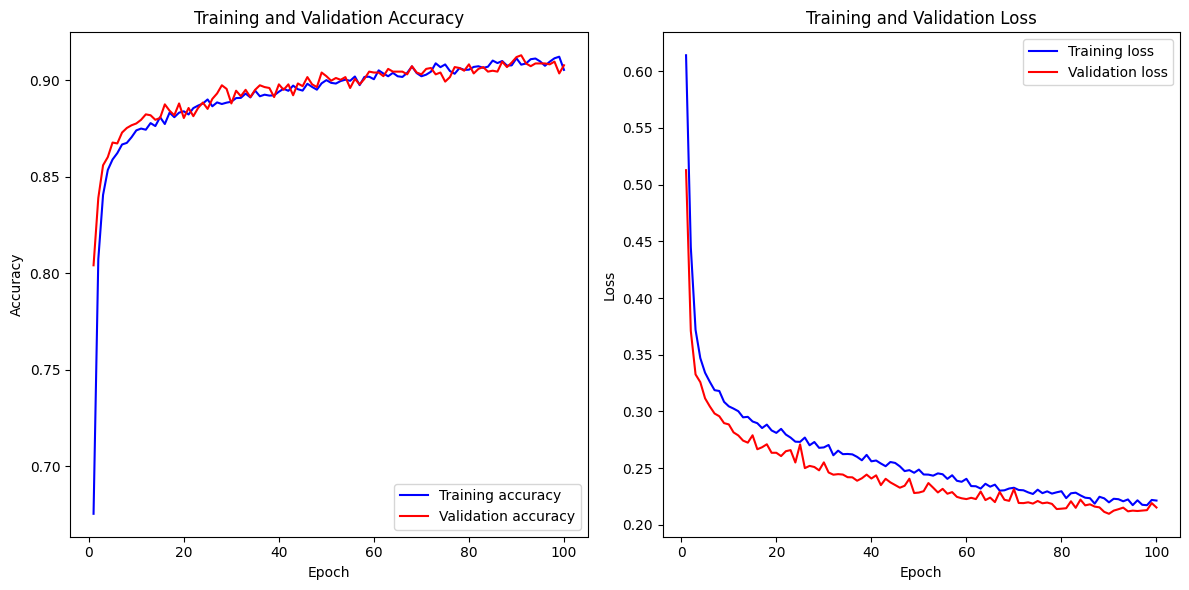

In [61]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Predictions
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculating additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # roc_auc_score expects probability scores

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9167 - loss: 0.2072
Test Accuracy: 0.9132523536682129
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precision: 0.8992154496077248
Recall: 0.9141104294478528
F1 Score: 0.9066017645269242
ROC AUC Score: 0.9714778559423074


In [4]:
import pandas as pd

# Load transactions from a CSV file
transactions_df = pd.read_csv('./data/transactions.csv')

# Convert the 'value' column to integers for calculation purposes
# This assumes all values in the 'value' column are numeric and can be converted to integers
transactions_df['value'] = transactions_df['value'].astype(int)

# Convert timestamps from string to datetime
transactions_df['timeStamp'] = pd.to_datetime(transactions_df['timeStamp'], unit='s')

# Calculate time differences in minutes for subsequent transactions
transactions_df.sort_values('timeStamp', inplace=True)
transactions_df['time_diff'] = transactions_df['timeStamp'].diff().dt.total_seconds() / 60

# Filter out sent and received transactions
sent_transactions = transactions_df[transactions_df['from'].str.lower() == '0x9A23A93905a0CEf884ACB6F6488BC5D7b964EF73'.lower()]
received_transactions = transactions_df[transactions_df['to'].str.lower() == '0x9A23A93905a0CEf884ACB6F6488BC5D7b964EF73'.lower()]

# Calculate various metrics with conversions from Wei to Ether
metrics = {
    'Avg min between sent tnx': sent_transactions['time_diff'].mean(),
    'Avg min between received tnx': received_transactions['time_diff'].mean(),
    'Time Diff between first and last (Mins)': (transactions_df['timeStamp'].iloc[-1] - transactions_df['timeStamp'].iloc[0]).total_seconds() / 60,
    'Unique Received From Addresses': received_transactions['from'].nunique(),
    'min value received': received_transactions['value'].min() / 1e18,
    'max value received ': received_transactions['value'].max() / 1e18,
    'avg val received': received_transactions['value'].mean() / 1e18,
    'min val sent': sent_transactions['value'].min() / 1e18,
    'avg val sent': sent_transactions['value'].mean() / 1e18,
    'total transactions (including tnx to create contract': transactions_df.shape[0],
    'total ether received': received_transactions['value'].sum() / 1e18,
    'total ether balance': transactions_df['value'].sum() / 1e18  # Simplistic balance calculation
}

In [5]:
metrics_df = pd.DataFrame([metrics])

In [6]:
for c in metrics_df.columns:
    if metrics_df[c].iloc[0] > 0:
        metrics_df[c] = np.log(metrics_df[c] + 1)

In [7]:
metrics_scaled = scaler.transform(metrics_df)

In [8]:
metrics_scaled

array([[0.49400726, 0.67545201, 0.9189675 , 0.27848886, 0.81830501,
        0.49151682, 0.51844038, 0.6536654 , 0.59898549, 0.73128432,
        0.42758327, 0.37626156]])

In [10]:
# Make predictions
prediction = model.predict(metrics_scaled)

# Output the prediction
print(f"Prediction: {prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction: 0.8538641929626465


In [11]:
model.output_names = ['output']
model.build(input_shape=(None, X_train_full.shape[1]))

In [12]:
# conversion based on the expected input shape
input_spec = [tf.TensorSpec([None, X_train_full.shape[1]], tf.float32, name='input')]

In [13]:
import onnxmltools
import tf2onnx

In [14]:
# Convert the model to ONNX format
onnx_model, _ = tf2onnx.convert.from_keras(model=model, input_signature=input_spec, opset=13)

2024-06-08 18:50:35.334788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:50:35.334877: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-06-08 18:50:35.335130: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-06-08 18:50:35.336930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 18:50:35.336968: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

In [76]:
onnx_file_path = './fraud-eth-account-detect.onnx'
with open(onnx_file_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

In [9]:
from giza.agents.model import GizaModel

MODEL_ID = 759 
VERSION_ID = 1  

def prediction(input, model_id, version_id):
    try:
        model = GizaModel(id=model_id, version=version_id)

        (result, proof_id) = model.predict(
            input_feed={'input': input}, verifiable=True
        )
        return result, proof_id
    except Exception as e:
        print("Failed to make prediction:", e)
        raise

def execution():

    input = metrics_scaled.astype(np.float32)

    (result, proof_id) = prediction(input, MODEL_ID, VERSION_ID)

    print((result, proof_id))

    return result, proof_id


execution()

{'job_size': 'M', 'args': '[1 12] [32375 0 44266 0 60225 0 18251 0 53628 0 32212 0 33976 0 42838 0 39255 0 47925 0 28022 0 24658 0]'}
🚀 Starting deserialization process...
✅ Deserialization completed! 🎉
(array([[0.84159851]]), 'e4ae19a0e7b74380977a36c83b1a4548')


(array([[0.84159851]]), 'e4ae19a0e7b74380977a36c83b1a4548')